Programmable state machines in rust
--------------------------------------------------------
- Author: [Timothy Hobbs](https://timothy.hobbs.cz)
- License: [CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/)
- Written: 12.2019
- Send PRs to: [github](https://github.com/timthelion/rust-jupyter)

[project homepage](https://github.com/timthelion/rust-pfsm) [ipynb](./pfsm.ipynb)

Rust has several finite state machine packages. However, all of them are meant for state machines who's state network is known at compile time. I needed a programmable state machine, so I turned to the petgraph library for help.

In [2]:
:dep petgraph-evcxr = {path="./petgraph-evcxr"}
:dep petgraph = {path="./petgraph"}

In [3]:
extern crate petgraph;
use petgraph::*;
use crate::petgraph::visit::*;
use petgraph::data::*;
use petgraph::graph::*;
use petgraph_evcxr::draw_graph_with_attr_getters;

I started by creating a struct:

In [4]:
struct StateMachine<'a, G, E, N, NW, EW, Transition>
where
  G:  GraphBase<EdgeId = E, NodeId = N>
    + Data<NodeWeight = NW, EdgeWeight = EW>,
  E: Copy + PartialEq,
  N: Copy + PartialEq,
{
  state_network: G,
  state: N,
  match_inputs: &'a dyn Fn(EW, EW) -> Option<Transition>,
}

This struct stores the FSM network as well as the current state.

In [5]:
fn get_id_for_state<'a, G, NW, EW>(network: &'a G, state: NW) -> Option<<&'a G as GraphBase>::NodeId>
where
    &'a G: IntoNodeReferences
           + GraphBase
           + DataMap
           + Data<NodeWeight = NW, EdgeWeight = EW>,
    NW: Eq,
{
  for nr in network.node_references() {
    if *(network.node_weight(nr.id())).unwrap() == state {
      return Option::Some(nr.id());
    }
  }
  return None
}

In [6]:
impl<'a, G, E, N, EW, NW, Transition> StateMachine<'a, G, E, N, NW, EW, Transition>
where
  G: Data<NodeWeight = NW, EdgeWeight = EW>
    + NodeIndexable
    + GraphProp
    + DataMap
    + GraphBase<EdgeId = E, NodeId = N>,
  E: Copy + PartialEq,
  N: Copy + PartialEq,
  for<'b> &'b G: IntoNodeReferences
    + IntoEdgeReferences
    + IntoEdges
    + Data<NodeWeight = NW, EdgeWeight = EW>
    + GraphBase<EdgeId = E, NodeId = N>,
  EW: Eq + Copy,
  NW: Eq + Copy,
{
  pub fn next<'c>(&'c mut self, input: EW) -> Option<(Transition, NW)> {
    for edge in (&self.state_network).edges(self.state) {
      match (self.match_inputs)(*edge.weight(), input) {
          Some(matched_transition) => {
             self.state = edge.target();
              return match self.state_network.node_weight(self.state) {
                Some(weight) => Some((matched_transition, *weight)),
                None => None,
              }; 
            }
          None => ()
      }
    }
    return None;
  }
    
  pub fn set_state<'c>(&'c mut self, state: NW) {
      get_id_for_state(&self.state_network, state).map(|id| self.state = id);
  }

  pub fn new(
    network: G,
    start: NW,
    match_inputs: &'a dyn Fn(EW, EW) -> Option<Transition>,  
  ) -> Option<StateMachine<'a, G, <G as GraphBase>::EdgeId, <G as GraphBase>::NodeId, NW, EW, Transition>> {
    get_id_for_state(&network, start).map(|id| StateMachine {
        state_network: network,
        state: id,
        match_inputs: match_inputs,
    })
  }
}

In [7]:
impl<'a, G, E, N, EW, NW, Transition> StateMachine<'a, G, E, N, NW, EW, Transition>
 where
    G: NodeIndexable
       + GraphProp
       + GraphBase<EdgeId = E, NodeId = N>
       + Data<NodeWeight = NW, EdgeWeight = EW>,
    E: Copy + PartialEq,
    N: Copy + PartialEq,
  for<'b> &'b G: IntoNodeReferences
    + IntoEdgeReferences
    + IntoEdges
    + GraphBase<EdgeId = E, NodeId = N>
    + Data<NodeWeight = NW, EdgeWeight = EW>,
    EW: std::fmt::Display,
    NW: std::fmt::Display,
{
    pub fn draw_evcxr(&self) {
        draw_graph_with_attr_getters(
            &self.state_network,
            &[],
            &|_, _| "".to_string(),
            &|_, nr| (if nr.id() == self.state { "shape = circle style = filled fillcolor = red" } else { "shape = circle" }).to_string(),
        );
    }
}

The logic is encoded in the `next` method, which takes an `Input` token and returns the next `State`. The input tokens and states can be anything.

In [14]:
let mut sn : Graph<&str, u32, petgraph::Directed> = Graph::new();
let sn_item1 = sn.add_node("a");
let sn_item2 = sn.add_node("b");
let sn_item3 = sn.add_node("c");
let sn_item4 = sn.add_node("d");
let sn_item5 = sn.add_node("e");
sn.add_edge(sn_item1, sn_item2, 1);
sn.add_edge(sn_item1, sn_item3, 2);
sn.add_edge(sn_item2, sn_item4, 1);
sn.add_edge(sn_item2, sn_item5, 2);
sn.add_edge(sn_item5, sn_item1, 2);
sn.add_edge(sn_item5, sn_item3, 1);
let mut sm = StateMachine::new(
    sn,
    "a",
    &|ew1, ew2| {
        if ew1 == ew2 {Some(())} else {None}
    },
).unwrap();

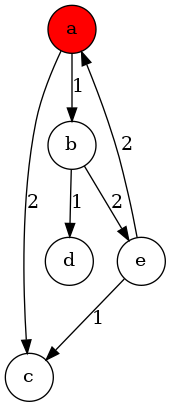

In [15]:
sm.draw_evcxr();

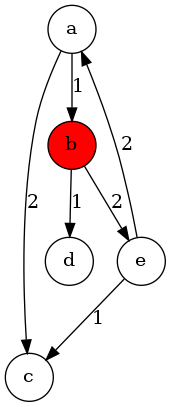

In [16]:
sm.next(1);
sm.draw_evcxr();

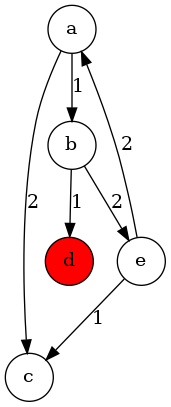

In [17]:
sm.next(1);
sm.draw_evcxr();

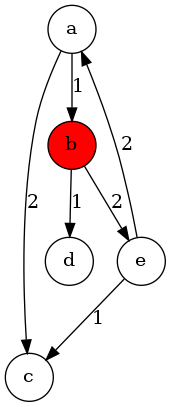

In [18]:
l
sm.draw_evcxr();

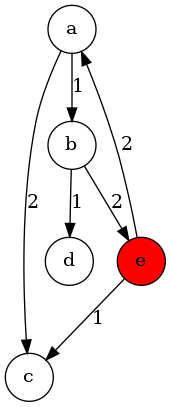

In [19]:
sm.next(2);
sm.draw_evcxr();

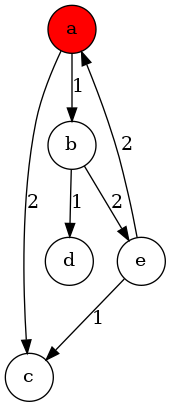

In [20]:
sm.next(2);
sm.draw_evcxr();

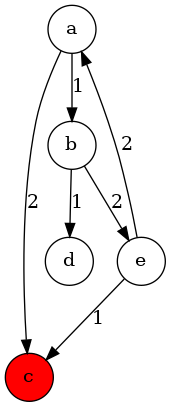

In [21]:
sm.next(2);
sm.draw_evcxr();